In [2]:
import datetime
import heliosat
import matplotlib
import numpy as np
import py3dcore
import pickle

from matplotlib import pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
from py3dcore.rotqs import _numba_quaternion_rotate
from scipy.optimize import least_squares

rc('font', **{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 28, 'weight': 'normal'})
rc('text', usetex=True)


def arc_solve(r, r0):
    func = lambda q: np.sqrt(np.sum((_numba_quaternion_rotate(np.array([0, r0[0], r0[1], r0[2]]), q) - r)**2))
    return least_squares (func, x0=np.array([1.0, 0, 0, 0])).x

def arc(r0, r1, N=100):
    # find quaternions for rotating (1., 0, 0) into r0 and r1, then slerp
    v0 = arc_solve(r0, r0)
    v1 = arc_solve(r1, r0)
    
    slerps = slerp(v0, v1, np.linspace(0, 1, N))

    return np.array([_numba_quaternion_rotate(np.array([0, r0[0], r0[1], r0[2]]), _) for _ in slerps])
    
def slerp(v0, v1, t_array):
    """Spherical linear interpolation."""
    """Code taken from https://en.wikipedia.org/wiki/Slerp#Quaternion_Slerp"""
    # >>> slerp([1,0,0,0], [0,0,0,1], np.arange(0, 1, 0.001))
    t_array = np.array(t_array)
    v0 = np.array(v0)
    v1 = np.array(v1)
    dot = np.sum(v0 * v1)

    if dot < 0.0:
        v1 = -v1
        dot = -dot
    
    DOT_THRESHOLD = 0.9995
    if dot > DOT_THRESHOLD:
        result = v0[np.newaxis,:] + t_array[:,np.newaxis] * (v1 - v0)[np.newaxis,:]
        return (result.T / np.linalg.norm(result, axis=1)).T
    
    theta_0 = np.arccos(dot)
    sin_theta_0 = np.sin(theta_0)

    theta = theta_0 * t_array
    sin_theta = np.sin(theta)

    s0 = np.cos(theta) - dot * sin_theta / sin_theta_0
    s1 = sin_theta / sin_theta_0
    return (s0[:,np.newaxis] * v0[np.newaxis,:]) + (s1[:,np.newaxis] * v1[np.newaxis,:])

/home/aweiss/miniconda3/envs/weiss2020_3dcore/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/aweiss/miniconda3/envs/weiss2020_3dcore/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/home/aweiss/miniconda3/envs/weiss2020_3dcore/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:64: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'z':


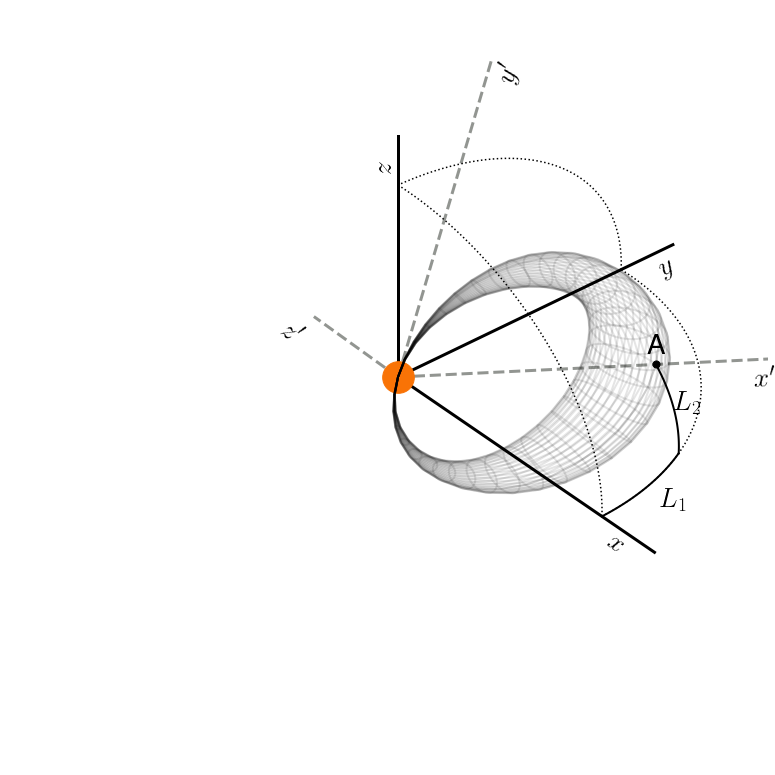

In [8]:
if __name__ == "__main__":
    t_l = datetime.datetime(2012, 1, 1)

    iparams_arr = np.array([[
            0,      # t0
            25,      # lon
            25,      # lat
            25,      # inc
            0.22,   # d_1au
            1.68,   # delta
            20,     # launch radius
            950,    # velocity
            5,     # twist
            1,      # mag coeff
            17,     # axial field strength
            0.5,    # drag param
            450,    # solar wind speed
            0       # noise
        ]], dtype=np.float32)

    model_obj = py3dcore.models.TTGHv1(t_l, runs=1, use_gpu=False)
    model_obj.update_iparams(iparams_arr, seed=42)
    model_obj.propagate(t_l + datetime.timedelta(hours=58))

    wf_model = model_obj.visualize_wireframe(index=0)
    
    fig = plt.figure(figsize=(14, 14))
    ax = fig.gca(projection='3d')
    
    ax.scatter(0, 0, 0, s=1000, color="xkcd:orange")
    ax.plot_wireframe(wf_model[:, :, 0], wf_model[:, :, 1], wf_model[:, :, 2], color="xkcd:black", alpha=.1, lw=2)
    
    std_kwargs =  {
        "lw": 3
    }
    
    # HCI Axes
    ax.plot([0, 1.2], [0, 0], [0, 0], color="xkcd:black", **std_kwargs)
    ax.plot([0, 0], [0, 1.2], [0, 0], color="xkcd:black", **std_kwargs)
    ax.plot([0, 0], [0, 0], [0, 1.2], color="xkcd:black", **std_kwargs)
    
    ax.text(1.1, -.12, 0, r"$x$", zdir=(1, 0, 0))
    ax.text(.1, 1 + .02, 0, r"$y$", zdir=(0, 1, 0))
    ax.text(0, -.1, 1.1, r"$z$", zdir=(0, 0, 1))
    
    # Internal Axes
    internal_kwargs = {
        "color": "xkcd:gray",
        "ls": "--"
    }
    
    xv = _numba_quaternion_rotate(np.array([0, 1.44, 0, 0]), model_obj.qs_xs[0])
    yv = _numba_quaternion_rotate(np.array([0, 0, 1.44, 0]), model_obj.qs_xs[0])
    zv = _numba_quaternion_rotate(np.array([0, 0, 0, 0.5]), model_obj.qs_xs[0])

    ax.plot([0, xv[0]], [0, xv[1]], [0, xv[2]], **internal_kwargs, **std_kwargs)
    ax.plot([0, yv[0]], [0, yv[1]], [0, yv[2]], **internal_kwargs, **std_kwargs)
    ax.plot([0, zv[0]], [0, zv[1]], [0, zv[2]], **internal_kwargs, **std_kwargs)

    xvt = xv - np.array([0, .15, .05])
    yvt = yv - np.array([-.065, 0.05, .05])
    zvt = zv - np.array([0, .15, .05])

    ax.text(*xvt, r"$x'$", zdir=xv)
    ax.text(*yvt, r"$y'$", zdir=yv)
    ax.text(*zvt, r"$z'$", zdir=zv)
    
    # apex point
    qarr = np.array([[1, np.pi, 0]], dtype=np.float32)
    sarr = np.empty_like(qarr)
    model_obj.transform_qs(sarr, qarr)
    ax.scatter(*sarr[0], color="xkcd:black", s=50)
    sarrt = sarr[0] - np.array([0, .04, -.08])
    ax.text(*sarrt, r"A")
    
    # apex distance
    rapex = np.linalg.norm(sarr)
    arc_longitude = arc(np.array([rapex, 0, 0]), np.array([0, rapex, 0]), N=180)[:50]
    ax.plot(arc_longitude[:, 0], arc_longitude[:, 1], arc_longitude[:, 2], ls="-", color="xkcd:black", lw=2)
    
    l1t = arc_longitude[45] - np.array([-0.15, 0.2, 0])
    ax.text(*l1t, r"$L_1$")
    
    rapex_proj = arc_longitude[-1]
    
    arc_latitude = arc(rapex_proj, sarr, N=90)
    ax.plot(arc_latitude[:, 0], arc_latitude[:, 1], arc_latitude[:, 2], ls="-", color="xkcd:black", lw=2)
    
    ax.text(*arc_latitude[45], r"$L_2$")
    
    arc_xy = arc(np.array([rapex, 0, 0]), np.array([0, rapex, 0]))
    ax.plot(arc_xy[:, 0], arc_xy[:, 1], arc_xy[:, 2], ls=":", color="xkcd:black")
    
    arc_yz = arc(np.array([0, rapex, 0]), np.array([0, 0, rapex]))
    ax.plot(arc_yz[:, 0], arc_yz[:, 1], arc_yz[:, 2], ls=":", color="xkcd:black")
    
    arc_zx = arc(np.array([0, 0, rapex]), np.array([rapex, 0, 0]))
    ax.plot(arc_zx[:, 0], arc_zx[:, 1], arc_zx[:, 2], ls=":", color="xkcd:black")

    ax.set_axis_off()
    ax.view_init(elev=35, azim=-40)
    ax.set_xlim([-.75, .75])
    ax.set_ylim([-.75, .75])
    ax.set_zlim([-.75, .75])